In [ ]:
%matplotlib inline


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.

For example, look at this network that classifies digit images:

.. figure:: /_static/img/mnist.png
   :alt: convnet

   convnet

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define this network:



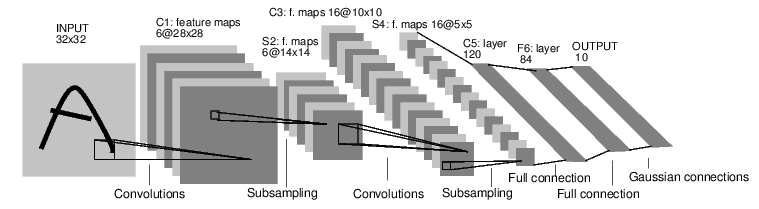


In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5) #pooling not inluence the number of Neuros in the Conv layer.
        self.conv2 = nn.Conv2d(6, 16, 5) #second Conv layer 
        #ouptut_h=(originalSize_h+padding*2-kernelSize_h)/stride +1
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #uisng relu fun change x value
        #type(x)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #print(x,self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x)) # self.num_flat_features() change the features to 1-dim vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #not use Activation function just weighted sum the input value from fc3
        return x

    def num_flat_features(self, x): #note that x means the whole input data, which means a Tensor(num_input*num_map*map_h
        #*map_w) a 4-dim Tensor
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:      #size =[n_fmaps,map_h,map_w] 
            num_features *= s
        return num_features


net = Net()
print(net)

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [17]:
params = list(net.parameters())
#print(params)
#there exsit five layers and each layer contain a set of link weight as well as a set of bias
#in this network pooling layers have not parameters
print(len(params))
print(params[0].size())  # conv1's .weight
print(params[1].size())
print(params[2].size()) # conv2 use full conneted works usually not full conneted can achieve better performance
print(params[4].size())
print(params[6].size())
print(params[8].size())

10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([120, 400])
torch.Size([84, 120])
torch.Size([10, 84])


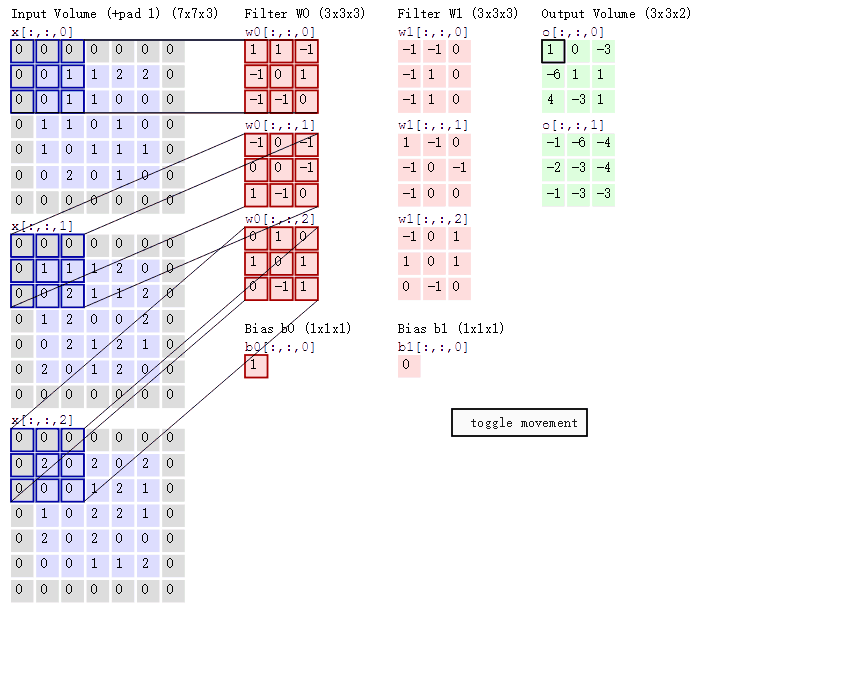

In [22]:
#how to understand filter. The type of fliter decide to the type of feature map. A fliter contain a set of base-filter, 
#it's number decided by the num of imput feature map
from IPython.display import Image
Image(filename="./ck.gif.png")

The input to the forward is an ``autograd.Variable``, and so is the output.
Note: Expected input size to this net(LeNet) is 32x32. To use this net on
MNIST dataset, please resize the images from the dataset to 32x32.



In [37]:
input = Variable(torch.randn(1, 1, 32, 32))
out = net(input)
print(out)



Variable containing:
-0.0892  0.0705  0.0697 -0.0114 -0.0421  0.0470  0.0809  0.0931  0.1042 -0.0182
[torch.FloatTensor of size 1x10]



Zero the gradient buffers of all parameters and backprops with random
gradients:



In [38]:
net.zero_grad() #Zero the gradient buffers of all parameters and backprops with random gradients:

#假设 x 经过一番计算得到 y，那么 y.backward(w) 求的不是 y 对 x 的导数，而是 l = torch.sum(y*w) 对 x 的导数。
#w 可以视为 y 的各分量的权重，也可以视为遥远的损失函数 l 对 y 的偏导数。也就是说，不一定需要从计算图最后的节点 y 
#往前反向传播，从中间某个节点 n 开始传也可以，只要你能把损失函数 l 关于这个节点的导数 dl/dn 记录下来，n.backward(dl/dn) 
#照样能往前回传，正确地计算出损失函数 l 对于节点 n 之前的节点的导数。特别地，若 y 为标量，w 取默认值 1.0，
#才是按照我们通常理解的那样，求 y 对 x 的导数。
out.backward(torch.randn(1, 10))

In [43]:
params[0].grad #the grad of the fisrt layer

Variable containing:
(0 ,0 ,.,.) = 
 -0.0592 -0.0106  0.0571  0.1290 -0.0035
  0.0773 -0.0162 -0.0955 -0.0467  0.0643
  0.1472  0.0324 -0.0682  0.0321 -0.0092
 -0.0120  0.0535  0.0048 -0.0046 -0.0270
  0.0481  0.0022  0.0218  0.0856  0.0348

(1 ,0 ,.,.) = 
 -0.0234 -0.0315  0.0098 -0.0390  0.0612
  0.0752  0.0396 -0.0298  0.0100 -0.0189
 -0.0405 -0.0170 -0.0040  0.0795 -0.0033
  0.0284 -0.0232 -0.0413  0.0774  0.0070
 -0.0097 -0.0103  0.0013 -0.0184  0.0415

(2 ,0 ,.,.) = 
  0.0798  0.0324  0.0944  0.0117  0.0235
 -0.0075 -0.0100  0.0904  0.1244  0.0273
  0.0312  0.0173 -0.0001 -0.0205  0.0302
  0.0127  0.0281  0.0452  0.0575 -0.0877
  0.0165  0.0490  0.0145 -0.0285 -0.0017

(3 ,0 ,.,.) = 
  0.0844 -0.0416  0.0713  0.0497  0.0301
 -0.0004 -0.0960  0.0257  0.0822 -0.0402
  0.0200  0.0328  0.0076  0.1453  0.0402
 -0.0059 -0.0701 -0.0116  0.0188 -0.0087
 -0.0524 -0.0059  0.0931  0.0488  0.1044

(4 ,0 ,.,.) = 
 -0.0016  0.0159 -0.0236  0.1175  0.0151
  0.0822  0.0036 -0.0463  0.0844 -0.054

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.</p></div>

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array*.
  -  ``autograd.Variable`` - *Wraps a Tensor and records the history of
     operations* applied to it. Has the same API as a ``Tensor``, with
     some additions like ``backward()``. Also *holds the gradient*
     w.r.t. the tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Variable, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Variable`` operation, creates at
     least a single ``Function`` node, that connects to functions that
     created a ``Variable`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <http://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



In [51]:
output = net(input)
target = Variable(torch.arange(1, 11))  # a dummy target, for example arrange [a,b)
#print(target)
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()
#print(output)
loss = criterion(output, target)
print(loss)

Variable containing:
 38.0341
[torch.FloatTensor of size 1]



Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Variables in the graph will have their
``.grad`` Variable accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [65]:
print(loss.creator)  # MSELoss
#print(type(loss.creator))
print(loss.creator.previous_functions)
#print(type(loss.creator.previous_functions))
print(loss.creator.previous_functions[0][0])
print(loss.creator.previous_functions[0][0].previous_functions[0][0])
print(loss.creator.previous_functions[0][0].previous_functions[0][0].previous_functions[0][0])
#print(loss.creator.next_functions[0][0])  # Linear
#print(loss.creator.next_functions[0][0].next_functions[0][0])  # ReLU

((<torch.nn._functions.linear.Linear object at 0x2ab9cb3be4a8>, 0), (<torch.autograd._functions.tensor.View object at 0x2ab9cb3be128>, 0))


Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [66]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
1.00000e-02 *
 -2.0265
 -1.2647
  1.7845
 -7.5493
  0.8522
 -4.7051
[torch.FloatTensor of size 6]



Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is `here <http://pytorch.org/docs/nn>`_.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [68]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

.. Note::

      Observe how gradient buffers had to be manually set to zero using
      ``optimizer.zero_grad()``. This is because gradients are accumulated
      as explained in `Backprop`_ section.



Actually. I find a good material from https://github.com/gaussic/pytorch-tutorial. If you use the PyTorch + Anaconda3, you can use this tutoial